##### source: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_NeuMF.ipynb

In [4]:
import os
import zipfile
from urllib import request

import pprint
pp = pprint.PrettyPrinter(indent=2)

# data science imports
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

In [9]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/', filename="data.zip")

extracting data.zip...
extracting data.zip done


In [10]:
def load_books():
    df = pd.read_csv('data/book-books.dat', sep=';', header=1, encoding="latin-1")
    df.columns = ['isbn', 'title', 'author', 'year_of_publication', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l']
    
    # insert custom index for word embedding training
    df.insert(0, 'bid', range(1, len(df) + 1))
    return df[['bid','isbn','title','author','year_of_publication','publisher']]

def load_users():
    df = pd.read_csv('data/book-users.dat', sep=';', header=1, encoding="latin-1")
    df.columns=['user_id', 'location', 'age']
    
    # insert custom index for word embedding training
    df.insert(0, 'uid', range(1, len(df) + 1))
    return df[['uid','user_id','location','age']]

def load_ratings():
    df = pd.read_csv('data/book-ratings.dat', sep=';', header=1, encoding="latin-1")
    df.columns=['user_id', 'isbn', 'rating']
    return df[['user_id','isbn','rating']]

In [12]:
books = load_books()
books

,bid,isbn,title,author,year_of_publication,publisher
0,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
2,3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
3,4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
4,5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
...,...,...,...,...,...,...
271354,271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271355,271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271356,271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271357,271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [13]:
users = load_users()
users

,uid,user_id,location,age
0,1,2,"stockton, california, usa",18.0
1,2,3,"moscow, yukon territory, russia",NaN
2,3,4,"porto, v.n.gaia, portugal",17.0
3,4,5,"farnborough, hants, united kingdom",NaN
4,5,6,"santa monica, california, usa",61.0
...,...,...,...,...
278852,278853,278854,"portland, oregon, usa",NaN
278853,278854,278855,"tacoma, washington, united kingdom",50.0
278854,278855,278856,"brampton, ontario, canada",NaN
278855,278856,278857,"knoxville, tennessee, usa",NaN


In [14]:
ratings = load_ratings()
ratings

,user_id,isbn,rating
0,276726,0155061224,5
1,276727,0446520802,0
2,276729,052165615X,3
3,276729,0521795028,6
4,276733,2080674722,0
...,...,...,...
1149774,276704,1563526298,9
1149775,276706,0679447156,0
1149776,276709,0515107662,10
1149777,276721,0590442449,10


In [15]:
# do some preprocessing to make sure data quality
ratings_clean_1 = ratings.merge(books, on='isbn', how='left', indicator=True)
ratings_clean_1 = ratings_clean_1[ratings_clean_1._merge != 'left_only']
ratings_clean_1 = ratings_clean_1.astype({'bid': 'int32'})
ratings_clean_1 = ratings_clean_1.drop(['_merge'], axis=1)
ratings_clean_1

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle
1,276727,0446520802,0,11053,The Notebook,Nicholas Sparks,1996,Warner Books
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
4,276733,2080674722,0,123639,Les Particules Elementaires,Michel Houellebecq,1998,Flammarion
...,...,...,...,...,...,...,...,...
1149773,276704,0876044011,0,69543,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig
1149774,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1149775,276706,0679447156,0,52540,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1149776,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books


In [16]:
# do some preprocessing to make sure data quality
ratings_clean_2 = ratings_clean_1.merge(users, on='user_id', how='left', indicator=True)
ratings_clean_2 = ratings_clean_2[ratings_clean_2.rating != 0]
ratings_clean_2 = ratings_clean_2.drop(['_merge'], axis=1)
ratings_clean_2

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle,276725,"seattle, washington, usa",NaN
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
5,276744,038550120X,7,9294,A Painted House,JOHN GRISHAM,2001,Doubleday,276743,"torrance, california, usa",NaN
12,276747,0060517794,9,4779,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,276746,"iowa city, iowa, usa",25.0
...,...,...,...,...,...,...,...,...,...,...,...
1031126,276704,0743211383,7,881,Dreamcatcher,Stephen King,2001,Scribner,276703,"cedar park, texas, usa",NaN
1031128,276704,0806917695,5,69541,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,276703,"cedar park, texas, usa",NaN
1031130,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,276703,"cedar park, texas, usa",NaN
1031132,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,276708,"mannington, west virginia, usa",38.0


In [17]:
num_users = len(ratings_clean_2.uid.unique())
num_items = len(ratings_clean_2.bid.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 68091 unique users and 149836 unique books in this data set


In [18]:
user_max_id = users.uid.max()
book_max_id = books.bid.max()
print('There are {} distinct users in ratings and the max of uid is {}'.format(num_users, user_max_id))
print('There are {} distinct books in ratings and the max of bid is {}'.format(num_items, book_max_id))

There are 68091 distinct users in ratings and the max of uid is 278857
There are 149836 distinct books in ratings and the max of bid is 271359


##### Split Data Into Train/Test

In [19]:
train, test = train_test_split(ratings_clean_2, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(train.shape)
print('shape of test data set:')
print(test.shape)

shape of training data set:
(307073, 11)
shape of test data set:
(76769, 11)


##### Train Generalized Matrix Factorization and Test Model

##### define GMF model architeture and train routine

In [20]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mf_embedding_user = Embedding(
        input_dim = num_users + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'user_embedding',
        embeddings_regularizer = l2(vu_reg),
        input_length = 1
    )
    
    mf_embedding_item = Embedding(
        input_dim = num_items + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'item_embedding',
        embeddings_regularizer = l2(vi_reg),
        input_length = 1
    ) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mf_embedding_user(user_input))
    item_latent = Flatten()(mf_embedding_item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs, filepath):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner, loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=filepath, monitor='val_rmse', save_best_only=True, save_weights_only=True)
    
    # train model
    history = model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[early_stopper, model_saver])
    
    return history

def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

##### create GMF model

In [21]:
GMF_model = get_GMF_model(user_max_id, book_max_id, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        2788580     user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        2713600     item_input[0][0]                 
______________________________________________________________________________________________

##### train GMF model

In [22]:
# model config
BATCH_SIZE = 4096
EPOCHS = 10000
VAL_SPLIT = 0.25

# train model
history = train_model(
    GMF_model,
    tf.keras.optimizers.Adam(0.1),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.bid.values],
    outputs=train.rating.values,
    filepath='model/neural-gmf-weights.hdf5')

Train on 230304 samples, validate on 76769 samples
Epoch 1/10000
230304/230304 [==============================] - 3s 12us/sample - loss: 30.6278 - mean_squared_error: 30.6278 - rmse: 5.3276 - val_loss: 9.5389 - val_mean_squared_error: 9.5389 - val_rmse: 3.0885
Epoch 2/10000
230304/230304 [==============================] - 2s 10us/sample - loss: 3.7679 - mean_squared_error: 3.7679 - rmse: 1.9307 - val_loss: 5.0499 - val_mean_squared_error: 5.0499 - val_rmse: 2.2472
Epoch 3/10000
230304/230304 [==============================] - 2s 10us/sample - loss: 1.1799 - mean_squared_error: 1.1799 - rmse: 1.0865 - val_loss: 4.7759 - val_mean_squared_error: 4.7759 - val_rmse: 2.1854
Epoch 4/10000
230304/230304 [==============================] - 2s 10us/sample - loss: 0.6799 - mean_squared_error: 0.6799 - rmse: 0.8238 - val_loss: 4.6161 - val_mean_squared_error: 4.6161 - val_rmse: 2.1484
Epoch 5/10000
230304/230304 [==============================] - 2s 10us/sample - loss: 0.4505 - mean_squared_error: 

230304/230304 [==============================] - 3s 12us/sample - loss: 0.1225 - mean_squared_error: 0.1225 - rmse: 0.3495 - val_loss: 4.1905 - val_mean_squared_error: 4.1905 - val_rmse: 2.0469
Epoch 41/10000
230304/230304 [==============================] - 3s 11us/sample - loss: 0.1106 - mean_squared_error: 0.1106 - rmse: 0.3315 - val_loss: 4.1229 - val_mean_squared_error: 4.1229 - val_rmse: 2.0302
Epoch 42/10000
230304/230304 [==============================] - 2s 9us/sample - loss: 0.1141 - mean_squared_error: 0.1141 - rmse: 0.3372 - val_loss: 4.1438 - val_mean_squared_error: 4.1438 - val_rmse: 2.0354
Epoch 43/10000
230304/230304 [==============================] - 2s 9us/sample - loss: 0.1057 - mean_squared_error: 0.1057 - rmse: 0.3243 - val_loss: 4.1755 - val_mean_squared_error: 4.1755 - val_rmse: 2.0431
Epoch 44/10000
230304/230304 [==============================] - 2s 9us/sample - loss: 0.1018 - mean_squared_error: 0.1018 - rmse: 0.3190 - val_loss: 3.9667 - val_mean_squared_error:

In [23]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

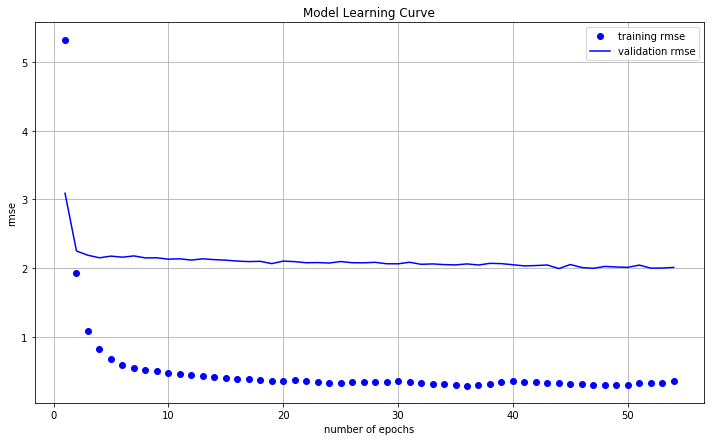

In [24]:
plot_learning_curve(history, 'rmse')

##### GMF model testing

In [25]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(test.rating.values))))

In [26]:
# load best model
GMF_model = get_GMF_model(user_max_id, book_max_id, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, 'model/neural-gmf-weights.hdf5')

# make prediction using test data
predictions = GMF_model.predict([test.uid.values, test.bid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.9944


#### Train Multi-Layer Perceptron Model and Test Model

##### define MLP model architeture

In [27]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    
    mlp_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mlp_embedding_user(user_input))
    item_latent = Flatten()(mlp_embedding_item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create MLP model

In [28]:
MLP_model = get_MLP_model(user_max_id, book_max_id, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        8923456     user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        8683520     item_input[0][0]                 
____________________________________________________________________________________________

##### train MLP model

In [29]:
# model config
BATCH_SIZE = 4096
EPOCHS = 10000
VAL_SPLIT = 0.25

# train model
history = train_model(
    MLP_model,
    tf.keras.optimizers.Adam(0.1),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.bid.values],
    outputs=train.rating.values,
    filepath='model/neural-mlp-weights.hdf5')

Train on 230304 samples, validate on 76769 samples
Epoch 1/10000
230304/230304 [==============================] - 8s 35us/sample - loss: 6.9507 - mean_squared_error: 6.9507 - rmse: 2.2888 - val_loss: 2.8398 - val_mean_squared_error: 2.8398 - val_rmse: 1.6845
Epoch 2/10000
230304/230304 [==============================] - 7s 32us/sample - loss: 1.9433 - mean_squared_error: 1.9433 - rmse: 1.3952 - val_loss: 2.9103 - val_mean_squared_error: 2.9103 - val_rmse: 1.7058
Epoch 3/10000
230304/230304 [==============================] - 8s 33us/sample - loss: 1.2951 - mean_squared_error: 1.2951 - rmse: 1.1388 - val_loss: 2.9997 - val_mean_squared_error: 2.9997 - val_rmse: 1.7318
Epoch 4/10000
230304/230304 [==============================] - 8s 33us/sample - loss: 0.9867 - mean_squared_error: 0.9867 - rmse: 0.9935 - val_loss: 3.0688 - val_mean_squared_error: 3.0688 - val_rmse: 1.7516
Epoch 5/10000
230304/230304 [==============================] - 7s 32us/sample - loss: 0.8148 - mean_squared_error: 0.

##### MLP learning curve

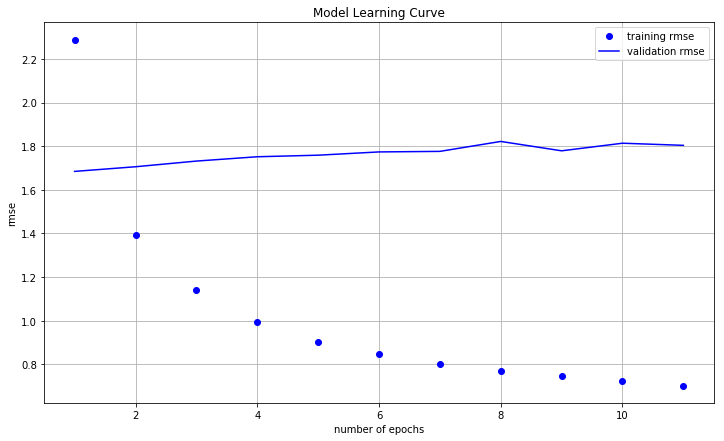

In [30]:
plot_learning_curve(history, 'rmse')

#### MLP model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [31]:
# load best model
MLP_model = get_MLP_model(user_max_id, book_max_id, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, 'model/neural-mlp-weights.hdf5')

# make prediction using test data
predictions = MLP_model.predict([test.uid.values, test.bid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.6834


#### Train Neural Matrix Factorization (NeuralMF) and Test Model

##### define NeuralMF model architeture

In [32]:
def get_NeuralMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuralMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # MF Embedding layer
    mf_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    
    mf_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    
    mlp_embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(mf_embedding_user(user_input))
    mf_item_latent = Flatten()(mf_embedding_item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(mlp_embedding_user(user_input))
    mlp_item_latent = Flatten()(mlp_embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])

    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create NeuralMF model

In [33]:
NeuralMF_model = get_NeuralMF_model(
    num_users=user_max_id,
    num_items=book_max_id,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        8923456     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        8683520     item_input[0][0]                 
____________________________________________________________________________________________

##### train NeuralMF model

In [34]:
# model config
BATCH_SIZE = 4096
EPOCHS = 100000
VAL_SPLIT = 0.25

# train model
history = train_model(
    NeuralMF_model,
    tf.keras.optimizers.Adam(0.1),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.bid.values],
    outputs=train.rating.values,
    filepath='model/neural-nmf-weights.hdf5')

Train on 230304 samples, validate on 76769 samples
Epoch 1/100000
230304/230304 [==============================] - 10s 45us/sample - loss: 8.6418 - mean_squared_error: 8.6418 - rmse: 2.5670 - val_loss: 3.0765 - val_mean_squared_error: 3.0765 - val_rmse: 1.7536
Epoch 2/100000
230304/230304 [==============================] - 10s 42us/sample - loss: 2.1055 - mean_squared_error: 2.1055 - rmse: 1.4503 - val_loss: 3.0214 - val_mean_squared_error: 3.0214 - val_rmse: 1.7379
Epoch 3/100000
230304/230304 [==============================] - 10s 42us/sample - loss: 1.2051 - mean_squared_error: 1.2051 - rmse: 1.0976 - val_loss: 3.0664 - val_mean_squared_error: 3.0664 - val_rmse: 1.7508
Epoch 4/100000
230304/230304 [==============================] - 10s 43us/sample - loss: 0.8036 - mean_squared_error: 0.8036 - rmse: 0.8960 - val_loss: 3.1529 - val_mean_squared_error: 3.1529 - val_rmse: 1.7753
Epoch 5/100000
230304/230304 [==============================] - 10s 43us/sample - loss: 0.6047 - mean_squared

##### Neural Matrix Factorization (NeuralMF) learning curve

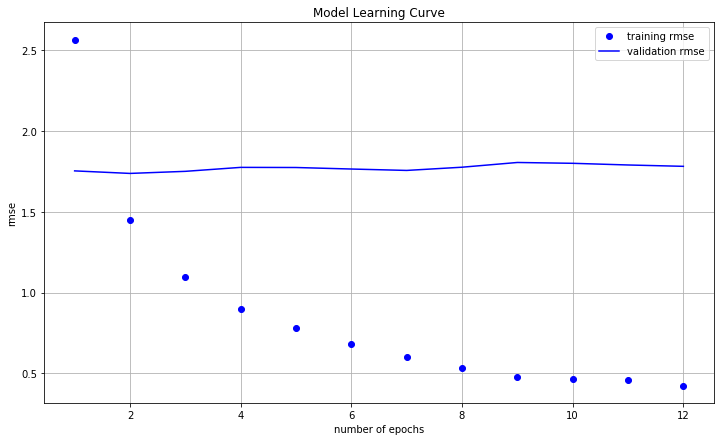

In [35]:
plot_learning_curve(history, 'rmse')

##### Neural Matrix Factorization (NeuralMF) model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [36]:
# load best model
NeuralMF_model = get_NeuralMF_model(
    num_users=user_max_id,
    num_items=book_max_id,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model = load_trained_model(NeuralMF_model, 'model/neural-nmf-weights.hdf5')

# make prediction using test data
predictions = NeuralMF_model.predict([test.uid.values, test.bid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.7331


##### Recommendation

In [37]:
# Creating dataset for making recommendations for the user
ratings_clean_2

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle,276725,"seattle, washington, usa",NaN
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
5,276744,038550120X,7,9294,A Painted House,JOHN GRISHAM,2001,Doubleday,276743,"torrance, california, usa",NaN
12,276747,0060517794,9,4779,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,276746,"iowa city, iowa, usa",25.0
...,...,...,...,...,...,...,...,...,...,...,...
1031126,276704,0743211383,7,881,Dreamcatcher,Stephen King,2001,Scribner,276703,"cedar park, texas, usa",NaN
1031128,276704,0806917695,5,69541,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,276703,"cedar park, texas, usa",NaN
1031130,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,276703,"cedar park, texas, usa",NaN
1031132,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,276708,"mannington, west virginia, usa",38.0


In [38]:
# user ratings
uid = 439
books_data = np.array(list(set(ratings_clean_2.bid)))
users_data = np.array([uid for i in range(len(books_data))])
ratings_clean_2[ratings_clean_2.uid == uid].sort_values(['rating'], ascending=[0])

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
9253,440,0743424425,10,502,The Shining,Stephen King,2001,Pocket,439,"brookfield, wisconsin, usa",16.0
9252,440,0393321576,8,501,Karl Marx: A Life,Francis Wheen,2001,W.W. Norton &amp; Company,439,"brookfield, wisconsin, usa",16.0
9254,440,0786868015,7,503,The Diary of Ellen Rimbauer: My Life at Rose Red,Joyce Reardon,2001,Hyperion,439,"brookfield, wisconsin, usa",16.0


In [39]:
# recommendations
predictions = NeuralMF_model.predict([users_data, books_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:10]

recommendations = ratings_clean_2[ratings_clean_2['bid'].isin(recommended_book_ids)]
recommendations = recommendations.drop_duplicates(subset='title', keep="last")
recommendations.head(15)

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
18880,4385,051506162X,10,18173,Lured into Dawn,Catherine Mills,1982,Jove,4384,"albq, new mexico, usa",33.0
655475,177233,0070064512,7,19438,"If Life Is a Bowl of Cherries, What Am I Doing...",Erma Bombeck,1978,McGraw-Hill,177232,"austin, texas, usa",23.0
685379,185233,0590455419,5,69539,The Addams Family,Elizabeth Faucher,1991,Scholastic Paperbacks (Mm),185232,"winnemucca, nevada, usa",31.0
828636,225199,0192833545,10,55888,Wuthering Heights (Oxford World's Classics),Emily Bronte,1998,Oxford University Press,225198,"toronto, ontario, canada",54.0
842004,227702,0671019872,5,94612,MY SECRET GARDEN,Nancy Friday,1998,Pocket,227701,"league city, texas, usa",42.0
931132,248325,0393323366,5,43842,A Dog's Ransom,Patricia Highsmith,2002,W. W. Norton &amp; Company,248324,"zaragoza, dc, spain",33.0
946984,251975,3442722497,8,6492,"Schnee, der auf Zedern fÃ?ÃÂ¤llt.",David Guterson,1998,Btb Bei Goldmann,251974,"eppstein, hessen, germany",30.0
966866,257700,0373711301,7,47571,A Husband Of Her Own,Brenda Novak,2003,Harlequin,257699,"slippery rock, pennsylvania, usa",22.0
1029736,276165,0312291639,9,2849,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,276164,"las vegas, nevada, usa",20.0
